In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 327M/331M [00:03<00:00, 131MB/s]
100% 331M/331M [00:03<00:00, 114MB/s]


In [6]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [8]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [9]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [10]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [11]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/49_1_1_20170113173337426.jpg....,49,1
1,/content/UTKFace/32_1_4_20170105164210618.jpg....,32,1
2,/content/UTKFace/45_0_4_20170117172212027.jpg....,45,0
3,/content/UTKFace/24_1_0_20170119211426377.jpg....,24,1
4,/content/UTKFace/41_0_1_20170117140422547.jpg....,41,0


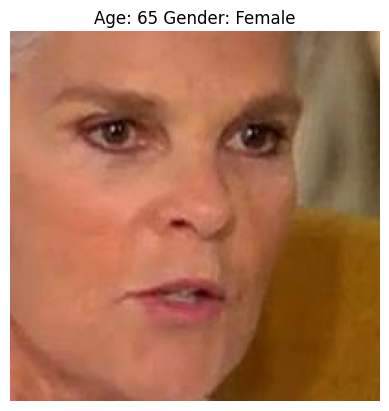

In [12]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

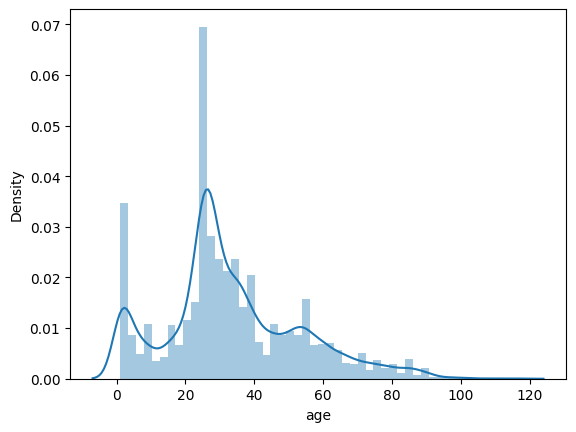

In [13]:
 sns.distplot(df['age'])

In [14]:
from tqdm import tqdm
import numpy as np
from PIL import Image
from PIL.Image import Resampling

def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        # Load the image in RGB format
        img = load_img(image)

        # Convert the image to grayscale
        img = img.convert('L')

        # Use Resampling.LANCZOS instead of Image.ANTIALIAS
        img = img.resize((128, 128), Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_image_features(df['image_path'])

100%|██████████| 23708/23708 [00:33<00:00, 703.98it/s]


In [15]:
X = X / 255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128, 128, 1)

In [18]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

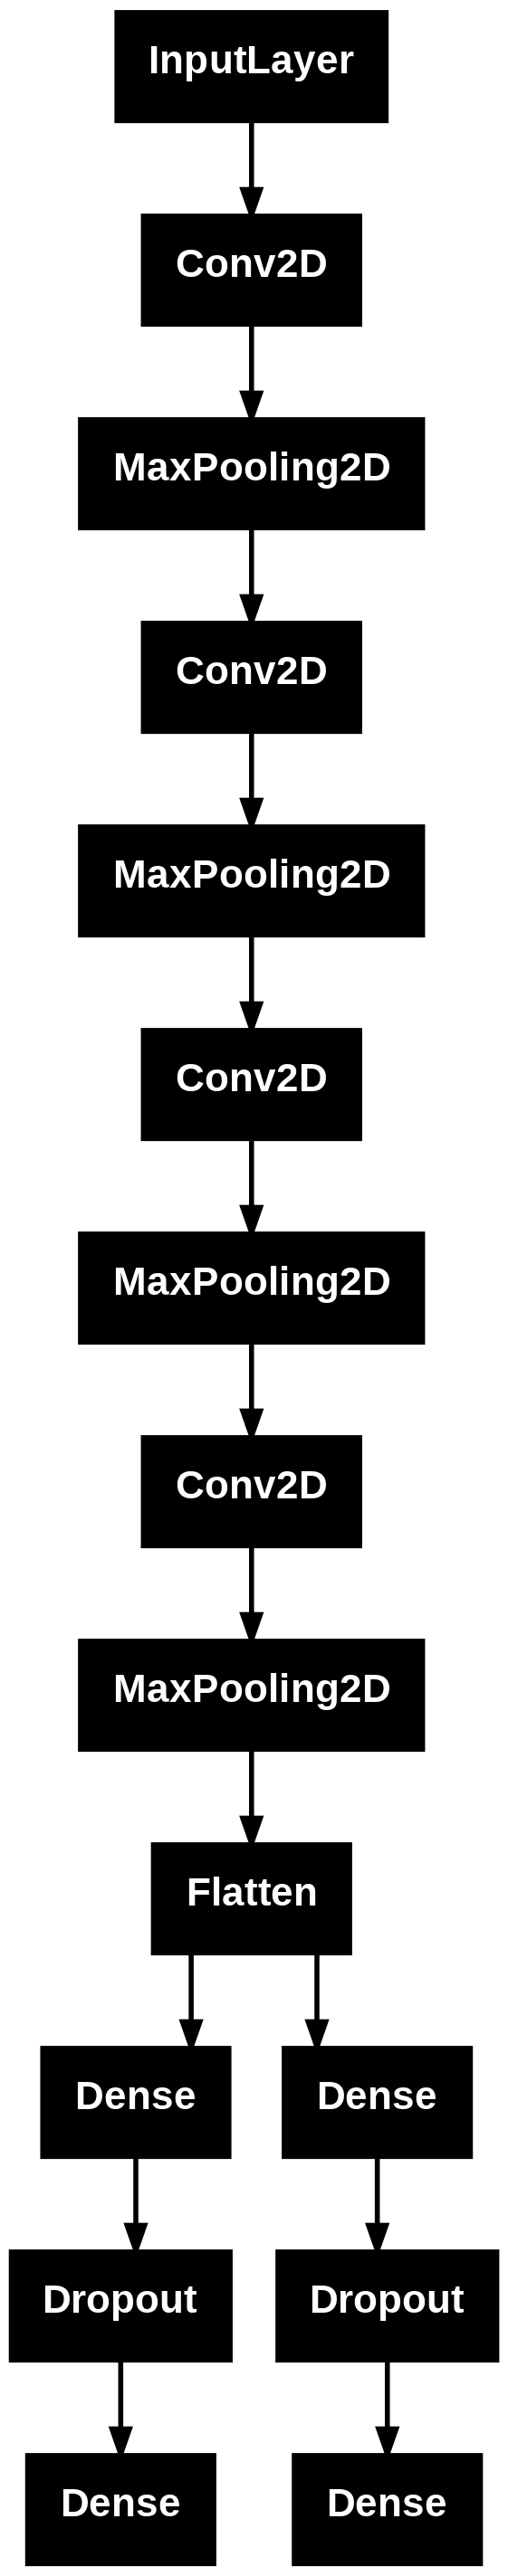

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'}) # Specify metrics per output

In [23]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=1, validation_split=0.2)

593/593 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - age_out_loss: 9.7864 - age_out_mae: 9.7864 - gender_out_accuracy: 0.7875 - gender_out_loss: 0.4528 - loss: 10.2392 - val_age_out_loss: 8.5399 - val_age_out_mae: 8.5553 - val_gender_out_accuracy: 0.8256 - val_gender_out_loss: 0.3742 - val_loss: 8.9306


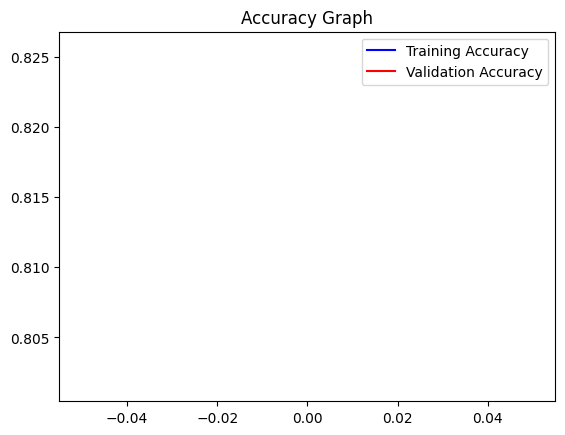

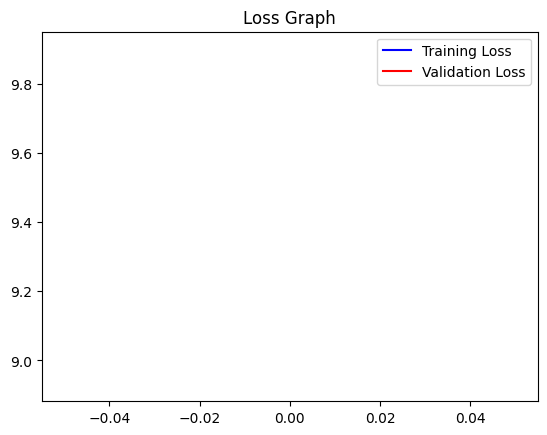

In [24]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Access the loss for the 'gender_out' output using the correct key
loss = history.history['loss']  # For overall loss, including gender_out loss
val_loss = history.history['val_loss'] # For overall validation loss, including gender_out validation loss

# ... (Rest of your plotting code)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [25]:
def get_image_features(image):
    # Use color_mode='grayscale' instead of grayscale=True
    img = load_img(image, color_mode='grayscale')
    # Replace Image.ANTIALIAS with Image.Resampling.LANCZOS
    img = img.resize((128, 128), Image.Resampling.LANCZOS)
    img = np.array(img)
    img = img.reshape(1, 128, 128, 1)
    img = img / 255.0
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


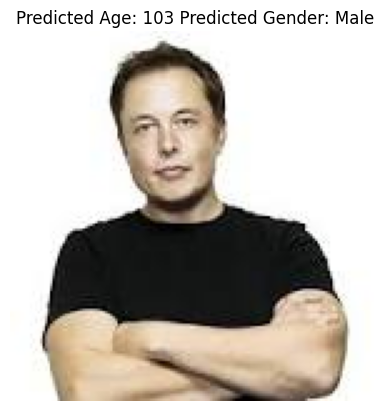

In [26]:
img_to_test = '/content/elon.jpeg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))